### Motivation:
Many *(?)* of scraped images do not actually depict asanas, these create noise in our labeled data. If we can strip these non-asanas out, we cn cleanup our labeled data and improve our model performance. By calculating image similarity, we can remove outlier images form our trining data. Doing so is possible via either 

    (a) human labeling (Mechanical Turk) or 
    (b) machine learning. Out of intellectual curiosity, 

I chose (b) even though (a) may be more time and cost effective.


There are three different ways we can compute image similarity [image-similarity-using-deep-ranking](https://medium.com/@akarshzingade/image-similarity-using-deep-ranking-c1bd83855978):

    (1) categorical: images are considered similar as long as they belong to the same category. This doesn't help us as we are looking to identify image similary *within* categories. 
    (2) feature extraction: Gabor filters, SIFT, Local Binary Patterns, HOG, etc. images are  considred similar if their features are similar 
    (3) Deep Ranking: learn fine-grained image similarity by characterising relationships within a set of triplets (a query image, a positive image, and a negative image)

# Housekeeping

In [3]:
import os
import glob
import sys
import cPickle as pickle

from ipywidgets import FloatProgress
import ipywidgets as widgets
from IPython.display import display
import time
import requests

import numpy as np
import pandas as pd
import os.path as path
from scipy import misc, stats
from skimage.transform import resize
from scipy.stats import describe
import matplotlib.pyplot as plt
import random
import cv2

import pathlib

from keras.models import Sequential, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
from keras.utils import to_categorical # For keras > 2.0
from keras.callbacks import ReduceLROnPlateau


%matplotlib inline

Using TensorFlow backend.


# Pick a Class

In [4]:
# list all image files
filepaths = glob.glob('dataset/google/*/*')
filepaths = [x for x in filepaths if os.path.splitext(x)[1]!='.json']

# create dataframe of filenames
filepaths_df = pd.DataFrame({'path': filepaths,\
                            'label': [x.split('/')[2] for x in filepaths]})

asana_list = filepaths_df.label.drop_duplicates().sort_values().tolist()
asana_choice = widgets.Dropdown(description='Asana: ', options=asana_list, value=None)
asana_choice

RHJvcGRvd24oZGVzY3JpcHRpb249dSdBc2FuYTogJywgb3B0aW9ucz0oJ0FkaG8rTXVraGErU3ZhbmFzYW5hJywgJ0FkaG8rTXVraGErVnJrc2FzYW5hJywgJ0FnbmlzdGFtYmhhc2FuYScsICfigKY=


In [7]:
print asana_choice.value

Urdhva+Dhanurasana


# Load Class Images

In [8]:
filepaths_sample_df = filepaths_df[filepaths_df.label==asana_choice.value].reset_index()
max_count = filepaths_sample_df.shape[0]
print("Loading %d images for asana %s..." % (max_count,asana_choice.value))


f = FloatProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
    
# Load the images, drop failed loads from df

images=[]
for i in range(len(filepaths_sample_df.path)):
    path = filepaths_sample_df.path[i]
    try:
        images.append(misc.imread(path))
    except:
        print "Failed to read in: %s, Dropping from dataframe" % path
        filepaths_sample_df = filepaths_sample_df.drop(i)
    f.value += 1
    
print
print("Number of images loaded: %d" %len(images))
print("Number of images in df: %d" %filepaths_sample_df.shape[0])

max_count = filepaths_sample_df.shape[0]

Loading 562 images for asana Urdhva+Dhanurasana...


FloatProgress(value=0.0, max=562.0)


Number of images loaded: 562
Number of images in df: 562


# Explore Images

dataset/google/Urdhva+Dhanurasana/Scrapper_362.jpg


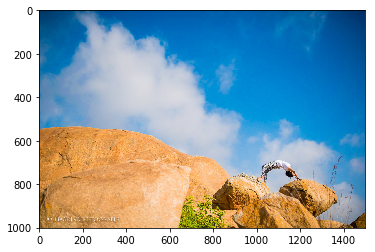

In [9]:
i=random.randint(0, max_count)
print filepaths_sample_df.path[i]
plt.imshow(images[i])

# Deep Ranking - VGG

[http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/](http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/)

We have to do a couple of preprocessing steps before feeding an image through the VGG16 model. The images must be resized to 224 x 224, the color channels must be normalized, and an extra dimension must be added due to Keras expecting to recieve multiple models. Thankfully, Keras has built-in functions to handle most of this.

In [10]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import scipy.sparse as sp

In [11]:
rand_img = filepaths_sample_df.path[i]
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


We can now load our model in and try feeding the image through.

In [12]:
# image_top=False removes final connected layers
model = VGG16(include_top=False, weights='imagenet')
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


We will later have to flatten the output of the model into a long feature vector. One thing that should be noted is the time that it takes to run a single model though the NN on a 32-core r4.8xlarge instance.

In [13]:
%%timeit -n5
pred = model.predict(x)

5 loops, best of 3: 88.8 ms per loop


In [14]:
print ("We're looking at %d seconds (%d minutes) for all %d asanas in class %s." % \
       (93.4*max_count, 93.4*max_count/60, max_count, asana_choice.value))

We're looking at 52490 seconds (874 minutes) for all 562 asanas in class Urdhva+Dhanurasana.


In [82]:
# # Grab relevant filenames
# get_mid = lambda x: x.split(os.path.sep)[-1].split('_')[0]
# fnames = filepaths_sample_df.path

# idx_to_mid = {}
# batch_size = 100
# min_idx = 0
# max_idx = min_idx + batch_size
# total_max = len(fnames)

# n_dims = pred.ravel().shape[0]
# px = 224

# # # Initialize predictions matrix
# preds = sp.lil_matrix((len(fnames), n_dims))

In [83]:
# while min_idx < total_max - 1:
#     t0 = time.time()
    
#     X = np.zeros(((max_idx - min_idx), px, px, 3))
    
#     # For each file in batch, 
#     # load as row into X
#     for i in range(min_idx, max_idx):
#         fname = fnames[i]
#         mid = get_mid(fname)
#         idx_to_mid[i] = mid
#         img = kimage.image.load_img(fname, target_size=(px, px))
#         img_array = kimage.image.img_to_array(img)
#         X[i - min_idx, :, :, :] = img_array
#         if i % 200 == 0 and i != 0:
#             t1 = time.time()
#             print('{}: {}'.format(i, (t1 - t0) / i))
#             t0 = time.time()
            
#     max_idx = i
#     t1 = time.time()
#     print('{}: {}'.format(i, (t1 - t0) / i))
    
#     print('Preprocess input')
#     t0 = time.time()
#     X = preprocess_input(X)
#     t1 = time.time()
#     print('{}'.format(t1 - t0))
    
#     print('Predicting')
#     t0 = time.time()
#     these_preds = model.predict(X)
#     shp = ((max_idx - min_idx) + 1, n_dims)
    
#     # Place predictions inside full preds matrix.
#     preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
#     t1 = time.time()
#     print('{}'.format(t1 - t0))
    
#     min_idx = max_idx
#     max_idx = np.min((max_idx + batch_size, total_max))
    
#     print


FloatProgress(value=0.0, max=562.0)

99: 0.0395131207476
Preprocess input
0.0450439453125
Predicting
7.14217305183


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


198: 0.0205920103824
Preprocess input
0.0447669029236
Predicting
6.96472001076
200: 0.000213240385056
297: 0.0107233973866
Preprocess input
0.0447659492493
Predicting
6.95040512085
396: 0.00847520972743
Preprocess input
0.0471711158752
Predicting
6.95364499092
400: 0.000216439962387
495: 0.00454935931196
Preprocess input
0.0473380088806
Predicting
6.92839407921
561: 0.00391050413543
Preprocess input
0.0319030284882
Predicting
4.63600897789


In [84]:
# pickle.dump( preds, open( "pickles/classify_play_03_imagesimilarity/preds.p", "wb" ) )

In [15]:
preds = pickle.load( open( "pickles/classify_play_03_imagesimilarity/preds.p", "rb" ) )

# Cosine Similarity

The preds matrix consists of a single row for each image with 25,088 sparse features as columns. To calculate item-item recommendations, we must convert this feature matrix into a similarity matrix.

In [88]:
# def cosine_similarity(ratings):
#     sim = ratings.dot(ratings.T)
#     if not isinstance(sim, np.ndarray):
#         sim = sim.toarray()
#     norms = np.array([np.sqrt(np.diagonal(sim))])
#     return (sim / norms / norms.T)

# preds = preds.tocsr()
# sim = cosine_similarity(preds)

In [242]:
# pickle.dump( sim, open( "pickles/classify_play_03_imagesimilarity/sim.p", "wb" ) )

In [16]:
sim = pickle.load( open( "pickles/classify_play_03_imagesimilarity/sim.p", "rb" ) )

Using the similarity matrix, we can reuse some old functions from previous posts to visualize some the recommendations. I've added on some HTML so that clicking on the images links out to their Sketchfab pages. Let's look at a couple!

# Examining a single image - top 50 and bottom50

dataset/google/Urdhva+Dhanurasana/Scrapper_262.jpg


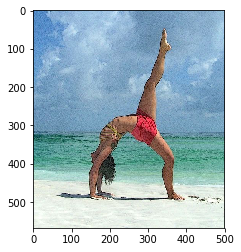

In [17]:
i=random.randint(0, max_count)
print filepaths_sample_df.path[i]
plt.imshow(images[i])

In [21]:
sim=sim; idx=i;  N=50
row = sim[idx, :]

thumbs_top = []
fnames_top = []
scores_top = []


thumbs_bot = []
fnames_bot = []
scores_bot = []

for x in np.argsort(-row)[:N]:
    fnames_top.append(filepaths_sample_df.path[x].split('/')[-1])
    thumbs_top.append(images[x])
    scores_top.append(np.round(row[x],2))

    
for x in np.argsort(row)[:N]:
    fnames_bot.append(filepaths_sample_df.path[x].split('/')[-1])
    thumbs_bot.append(images[x])
    scores_bot.append(np.round(row[x],2))

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


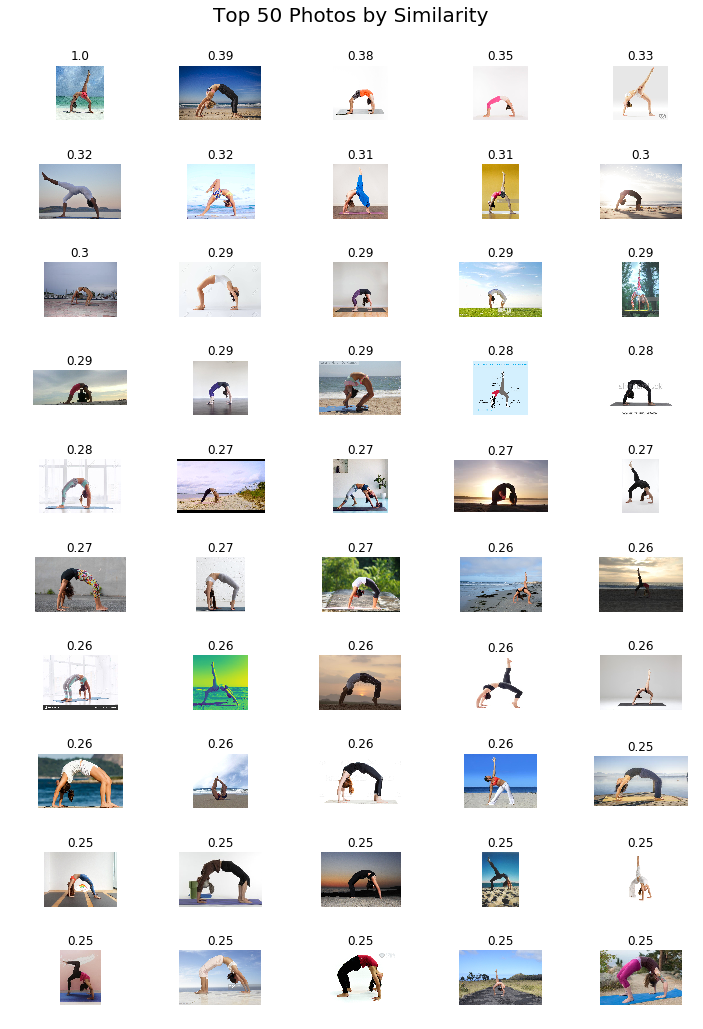

In [22]:
f = plt.figure(figsize=(10,15))
for i in range(len(thumbs_top)):
    ax = f.add_subplot(10,5,i+1)
    ax.imshow(thumbs_top[i])
    ax.axis('off')       
    ax.set_title(scores_top[i])
    ax = None
    
f.suptitle('Top 50 Photos by Similarity', fontsize=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

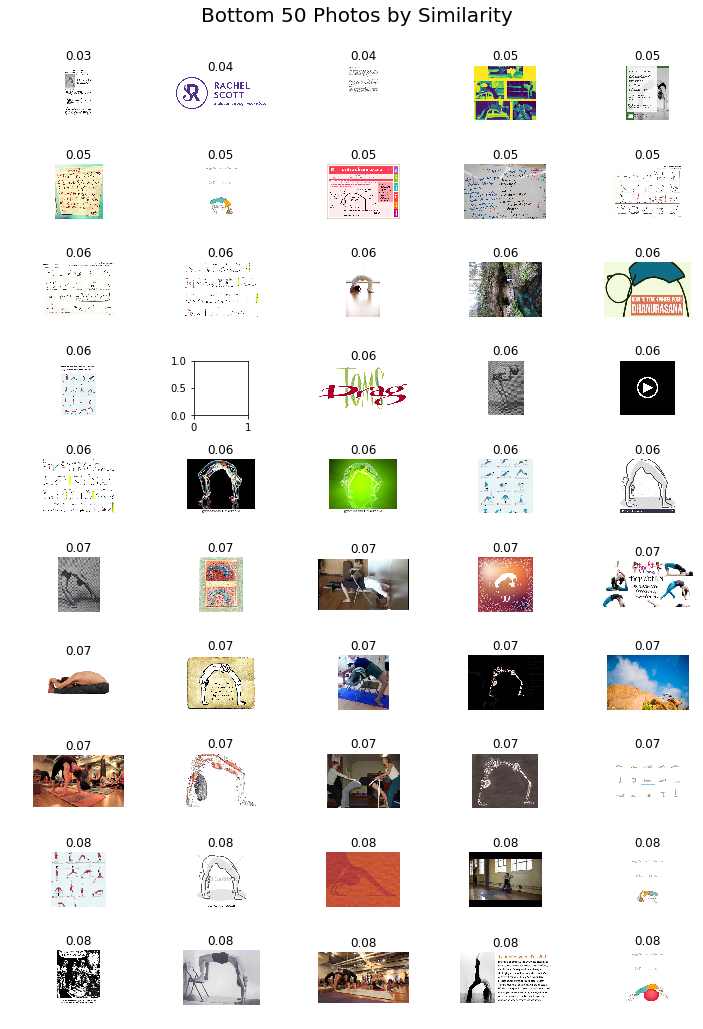

In [26]:
f = plt.figure(figsize=(10,15))
for i in range(len(thumbs_bot)):
    try:
        ax = f.add_subplot(10,5,i+1)
        ax.imshow(thumbs_bot[i])
        ax.axis('off')       
        ax.set_title(scores_bot[i])
        ax = None
    except:
        pass
        
    
f.suptitle('Bottom 50 Photos by Similarity', fontsize=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

Text(0.5,1,'Sorted Similarity Scores')

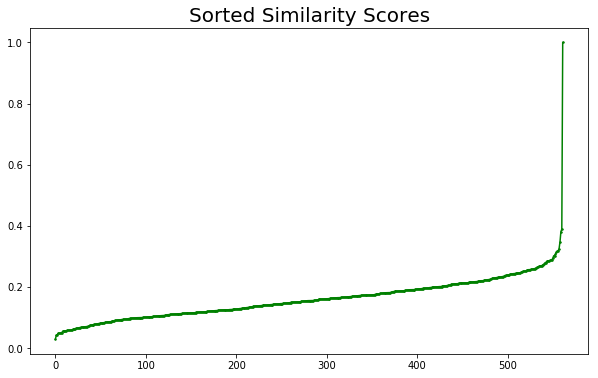

In [27]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(np.sort(row), color='green', marker='.', markersize=3)
ax.set_title('Sorted Similarity Scores', fontdict={'fontsize': 20})


In [28]:
row_diff = np.diff(np.sort(row))
print describe(row_diff)
np.percentile(row_diff,95)

DescribeResult(nobs=561, minmax=(3.065379747257957e-07, 0.6114256308127939), mean=0.001730180188869319, variance=0.0006687374499732335, skewness=23.4278751964519, kurtosis=549.752995493261)


0.0016615005041142605

Text(0.5,1,'Diff of Sorted Similarity Scores')

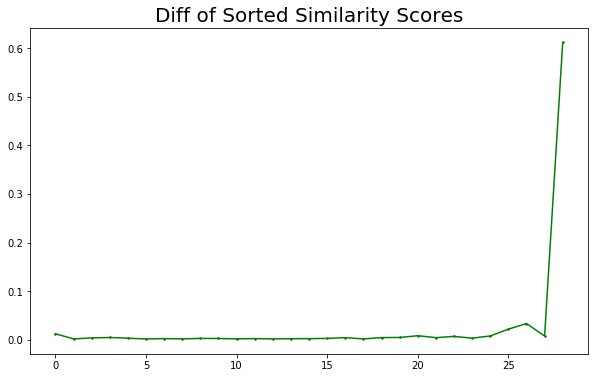

In [29]:
row_diff_95 = row_diff[row_diff>=np.percentile(row_diff,95)]

fig = plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(row_diff_95, color='green', marker='.', markersize=3)
ax.set_title('Diff of Sorted Similarity Scores', fontdict={'fontsize': 20})


Manually examining the lowest 50 cosine similarity score, it appears as though anything <.05 is not similar enough to be considered of the same class. 

# Clustering

We can sume the cosine similarity matrix `sim` as an input to a clustering algorithm to determine how this would generalize for the entire class of `asana_choice`.

In [30]:
print sim.shape

(562, 562)


In [31]:
from sklearn.cluster import KMeans

eigen_values, eigen_vectors = np.linalg.eigh(sim)
clust_km = KMeans(n_clusters=2, init='k-means++').fit_predict(eigen_vectors[:, 2:4])


In [32]:
clust1 = sim[clust_km==1,]
scors1 = row[clust_km==1]
clust2 = sim[clust_km==0,]
scors0 = row[clust_km==0]

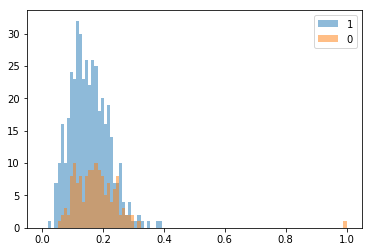

In [33]:
bins = np.linspace(0, 1, 100)
plt.hist(scors1, bins=bins, alpha=0.5, label='1')
plt.hist(scors0, bins=bins, alpha=0.5, label='0')
plt.legend(loc='upper right')
plt.show()

Examining the distribution of cosine similarity scores to our randomly selected image shows not much of a difference between the two clusters.

We try another clustering method -- hierarchical clustering 

Maybe use outlier detection to strip out non-similar images instead of trying to cluster them?

# DBSCAN

http://scikit-learn.org/stable/modules/clustering.html#dbscan

- clusters can be found of any shape
- not all pints have to belong to a cluster (food for outlier detection)
- clusters defined by core samples (samples that are in areas of high density) 
- clusters also contain non-core samples 
- guided by 2 parameters, define "dense":
    - min_samples 
    - eps
    - a core sample is defined as a point  in the dataset s.t. there exist min_samples other samples within a distance of eps
    - Higher min_samples or lower eps indicate higher density necessary to form a cluster.

The core sample is in a dense area of the vector space. 

A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least eps in distance from any core sample, is considered an outlier by the algorithm.


In [38]:
print sim.shape
print sim.std(0).mean()
print sim.mean(0).mean()

(562, 562)
0.06343834291952485
0.13380273480906907


In [40]:
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(sim)
print X.shape
print X.std(0).mean()
print X.mean(0).mean()

(562, 562)
1.0
-6.28697392386614e-17


In [ ]:
# Compute DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.00000000000005, min_samples=50, metric ="precomputed").fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.

from sklearn import metrics
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

In [ ]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
X_core = X[class_member_mask & core_samples_mask]
X_outl = X[class_member_mask & ~core_samples_mask]

In [ ]:
print "Number of core samples: %d " % sum(core_samples_mask)
print "Number of non-core samples: %d " % (len(X)-sum(core_samples_mask))

In [121]:
len(core_samples_mask)

562

In [122]:
thumbs = np.array(images)

thumbs_core = thumbs[np.array(core_samples_mask)] 
fnames_core = [x.split('/')[-1] for x in filepaths_sample_df.path[core_samples_mask]]
scores_core = np.round(row[core_samples_mask],2)

thumbs_outl = thumbs[np.array(~core_samples_mask)] 
fnames_outl = [x.split('/')[-1] for x in filepaths_sample_df.path[~core_samples_mask]]
scores_outl = np.round(row[~core_samples_mask],2)

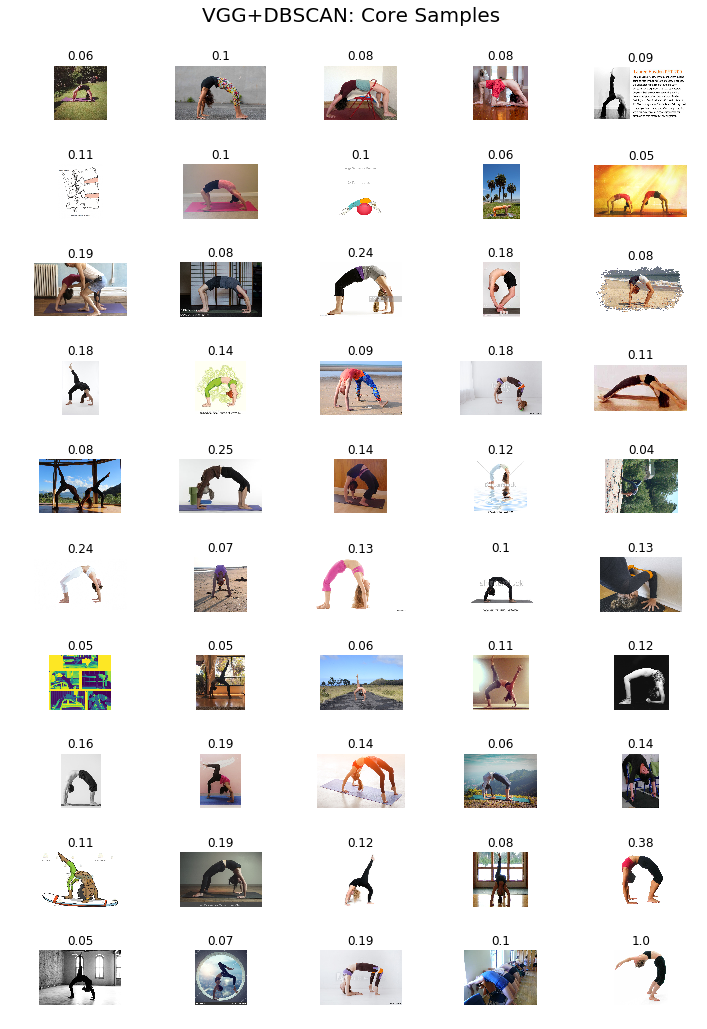

In [123]:
f = plt.figure(figsize=(10,15))
for i in range(len(thumbs_top)):
    ax = f.add_subplot(10,5,i+1)
    ax.imshow(thumbs_core[i])
    ax.axis('off')       
    ax.set_title(scores_core[i])
    ax = None
    
f.suptitle('VGG+DBSCAN: Core Samples', fontsize=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

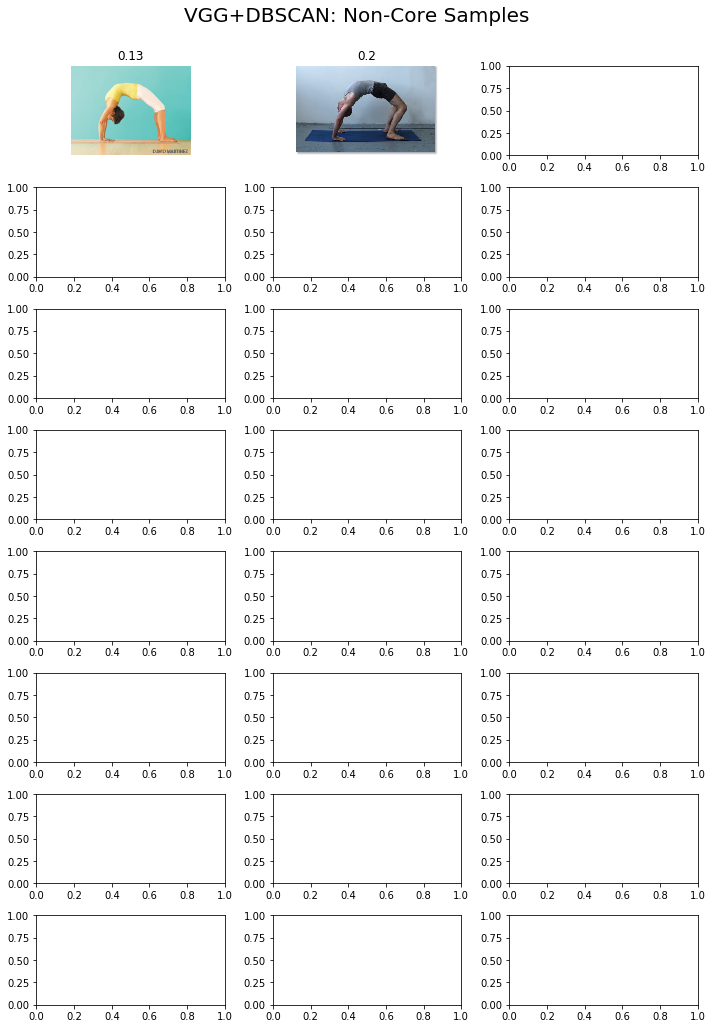

In [124]:
f = plt.figure(figsize=(10,15))
for i in range(len(thumbs_bot)):
    try:
        ax = f.add_subplot(8,3,i+1)
        ax.imshow(thumbs_outl[i])
        ax.axis('off')       
        ax.set_title(scores_outl[i])
        ax = None
    except:
        pass
        
    
f.suptitle('VGG+DBSCAN: Non-Core Samples', fontsize=20)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.show()

Both core samples and non-core samples look very similar.